<a href="https://colab.research.google.com/github/alinaprolygina/osda/blob/main/NeuralFCA_Big_hw_data1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [1]:
import sys
print(sys.executable)


/usr/bin/python3


In [2]:
import sys
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [3]:
import numpy as np
import pandas as pd

In [4]:
import torch

In [5]:
!pip3 install 'fcapy[all]'
!pip3 install frozendict
!pip3 install ipynb
!pip3 install sparselinear
!pip3 install bitsets
!pip3 install bitarray
import torch
!pip3 install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip3 install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip3 install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip3 install git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.8 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=250d6078a8dc1ba2326d06cfc297451960c3f54d78c1732c9a26f9b62b4cf844
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cuda118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=495091 sha256=f691f3551b8ab28ebb88a728910cc8df2be0f996c85e9b6cc78820e83943ea0f
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cuda118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1035675 sha256=bf7f6d748d424dcc76a1c783fdbbcbf173fb17d34c6fdb004f396ff6a1aaa8b4
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully buil

In [405]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

In [406]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [407]:
import neural_lib as nl

In [408]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
# df["DEATH_EVENT"].value_counts().sort_index()

In [409]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Pipeline

# Step 0. Binarize the data

In [411]:
df_bin = df

# Create a function for binarization
def binarize_column(df, column, intervals):
    for i, (low, high) in enumerate(intervals):
        if high is None:  # If upper limit is absent
            col_name = f'{column}_>{low}'
            df[col_name] = df[column].apply(lambda x: 1 if x > low else 0)
        elif low is None:  # If lower limit is absent
            col_name = f'{column}_<{high}'
            df[col_name] = df[column].apply(lambda x: 1 if x < high else 0)
        else:
            col_name = f'{column}_{low}-{high}'
            df[col_name] = df[column].apply(lambda x: 1 if low <= x < high else 0)

# Define intervals for each column
age_intervals = [(None, 50), (50, 70), (70, None)]
cpk_intervals = [(None, 26), (26, 350), (350, None)]
ef_intervals = [(None, 40), (41, 49), (50, 71), (71, None)]
sc_intervals = [(None, 0.6), (0.61, 1.3), (1.3, None)]
ss_intervals = [(None, 135), (135, 145), (145, None)]
pl_intervals = [(None, 150), (150, 450), (450, None)]
time_intervals = [(None, 31), (31, 151), (151, None)]

# Apply the function to each column
binarize_column(df_bin, 'age', age_intervals)
binarize_column(df_bin, 'creatinine_phosphokinase', cpk_intervals)
binarize_column(df_bin, 'ejection_fraction', ef_intervals)
binarize_column(df_bin, 'serum_creatinine', sc_intervals)
binarize_column(df_bin, 'serum_sodium', ss_intervals)
binarize_column(df_bin, 'platelets', pl_intervals)
binarize_column(df_bin, 'time', time_intervals)

# Remove original columns
df_bin.drop(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'platelets', 'time'], axis=1, inplace=True)

# Remove irrelevant columns
df_bin.drop(['platelets_<150', 'platelets_150-450', 'platelets_>450', 'serum_sodium_>145', 'serum_creatinine_<0.6', 'ejection_fraction_>71', 'creatinine_phosphokinase_<26'], axis=1, inplace=True)

# Save the "DEATH_EVENT" column into a separate variable
death_event_column = df_bin['DEATH_EVENT']

# Remove the "DEATH_EVENT" column from the original dataframe
df_bin = df_bin.drop('DEATH_EVENT', axis=1)

# Add the "DEATH_EVENT" column back into the dataframe, placing it at the end
df_bin['DEATH_EVENT'] = death_event_column

df_bin = df_bin.replace({1: True, 0: False})

# Check the result
df_bin

,anaemia,diabetes,high_blood_pressure,sex,smoking,age_<50,age_50-70,age_>70,creatinine_phosphokinase_26-350,creatinine_phosphokinase_>350,...,ejection_fraction_41-49,ejection_fraction_50-71,serum_creatinine_0.61-1.3,serum_creatinine_>1.3,serum_sodium_<135,serum_sodium_135-145,time_<31,time_31-151,time_>151,DEATH_EVENT
0,False,False,True,True,False,False,False,True,False,True,...,False,False,False,True,True,False,True,False,False,True
1,False,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,True,False,False,True
2,False,False,False,True,True,False,True,False,True,False,...,False,False,False,False,True,False,True,False,False,True
3,True,False,False,True,False,False,True,False,True,False,...,False,False,False,True,False,True,True,False,False,True
4,True,True,False,False,False,False,True,False,True,False,...,False,False,False,True,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,False,True,True,True,True,False,True,False,True,False,...,False,False,True,False,False,True,False,False,True,False
295,False,False,False,False,False,False,True,False,False,True,...,False,False,True,False,False,True,False,False,True,False
296,False,True,False,False,False,True,False,False,False,True,...,False,True,True,False,False,True,False,False,True,False
297,False,False,False,True,True,True,False,False,False,True,...,False,False,False,True,False,True,False,False,True,False


Split the data to train and test

In [412]:
# # List of columns to keep
# columns_to_keep = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'age_<50', 'age_50-70', 'age_>70', 'creatinine_phosphokinase_<26', 'creatinine_phosphokinase_26-350', 'creatinine_phosphokinase_>350', 'DEATH_EVENT']

# # Remove all columns except the ones listed
# df_bin = df_bin[columns_to_keep]

# # Print the first few rows to check
# print(df_bin.head())

In [413]:
from sklearn.model_selection import train_test_split
y_feat = 'DEATH_EVENT'
# # Total number of rows in the dataset
# total_rows = len(df_bin)

# # Size of the test sample
# test_size = 150

# # Index from which the data will go into the test sample
# test_start_index = total_rows - test_size

# # Split into training and test sets
# df_train = df_bin.iloc[:test_start_index]
# df_test = df_bin.iloc[test_start_index:]
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

In [414]:
X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]

In [236]:
!pip install imbalanced-learn


In [415]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

# smote = SMOTE(random_state=0)
# X_train, y_train = smote.fit_resample(X_train, y_train)


In [416]:
print("Unique class labels in the training set:", y_train.unique())
# Counting the number of samples for each class in the training dataset
class_counts = y_train.value_counts()
print("Class counts in training set:")
print(class_counts)

# Optionally, you can calculate the percentage ratio for each class
class_proportions = class_counts / len(y_train)
print("\nClass proportions in training set:")
print(class_proportions)

Unique class labels in the training set: [False  True]
Class counts in training set:
False    141
True     141
Name: DEATH_EVENT, dtype: int64

Class proportions in training set:
False    0.5
True     0.5
Name: DEATH_EVENT, dtype: float64


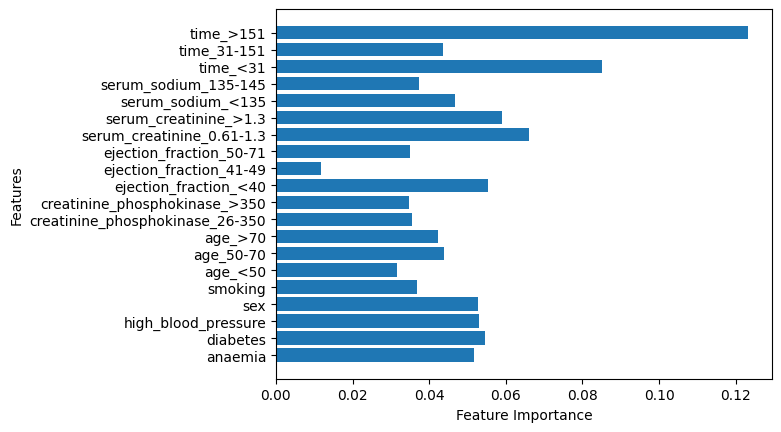

In [417]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Training the random forest to assess the importance of features
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Visualization of feature importances
plt.barh(X_train.columns, rf.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [418]:
# Converting indexes to strings
# X_train.index = X_train.index.map(str)
# K_train = FormalContext.from_pandas(X_train)
K_train = FormalContext(data=X_train.values, target = y_train.values, attribute_names=X_train.columns)
K_train

FormalContext (282 objects, 20 attributes, 2218 connections)
   |anaemia|diabetes|high_blood_pressure|sex|smoking|...|serum_sodium_<135|serum_sodium_135-145|time_<31|time_31-151|time_>151|
0  |       |        |                   |  X|      X|...|                 |                   X|        |           |        X|
1  |      X|       X|                   |   |       |...|                 |                   X|        |          X|         |
2  |       |       X|                   |  X|      X|...|                 |                   X|        |           |        X|
3  |       |        |                  X|   |       |...|                 |                   X|        |           |        X|
4  |       |        |                  X|  X|      X|...|                X|                    |        |          X|         |
5  |      X|        |                   |  X|       |...|                X|                    |        |          X|         |
6  |       |        |                  X|  

In [419]:
%%time
L = ConceptLattice.from_context(K_train, algo='Sofia', is_monotone=True)
len(L)

CPU times: user 173 ms, sys: 917 µs, total: 174 ms
Wall time: 176 ms


93

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [420]:
from sklearn.metrics import f1_score
from frozendict import frozendict

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1

    # Copying and modifying data
    updated_measures = dict(c.measures)
    updated_measures['f1_score'] = f1_score(y_train, y_preds)

    # Updating c.measures with the new frozendict
    c.measures = frozendict(updated_measures)

# for c in L:
#     y_preds = np.zeros(K_train.n_objects)
#     y_preds[list(c.extent_i)] = 1
#     c.measures['f1_score'] = f1_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [443]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:30])

print(len({g_i for c in L[best_concepts] for g_i in c.extent_i}))
print(K_train.n_objects)

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

282
282


Construct neural network based on concept lattice

In [444]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [445]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

Move the nodes in visualization to make it look pretty

In [446]:
# vis.init_mover_per_poset(cn.poset)
# mvr = vis.mover
# for a, b in [(11, 15), (2, 3), (2,8), (2, 4), (4,5), (24, 26), (22, 26), (23, 25), (22, 24), (6, 7), ]:
#     mvr.swap_nodes(a, b)

# for nodes, vert in [
#     ([19, 18], 0), ([23, 22], 5), ([14, 21,20], 1), ([13, 24, 25], 6), ([26], 7), ([9, 15], 8)
# ]:
#     for a in nodes:
#         mvr.place_node(a, mvr.posx[vert])

In [447]:
descr = {'anaemia', 'smoking', 'high_blood_pressure'}

traced = cn.trace_description(descr, include_targets=False)

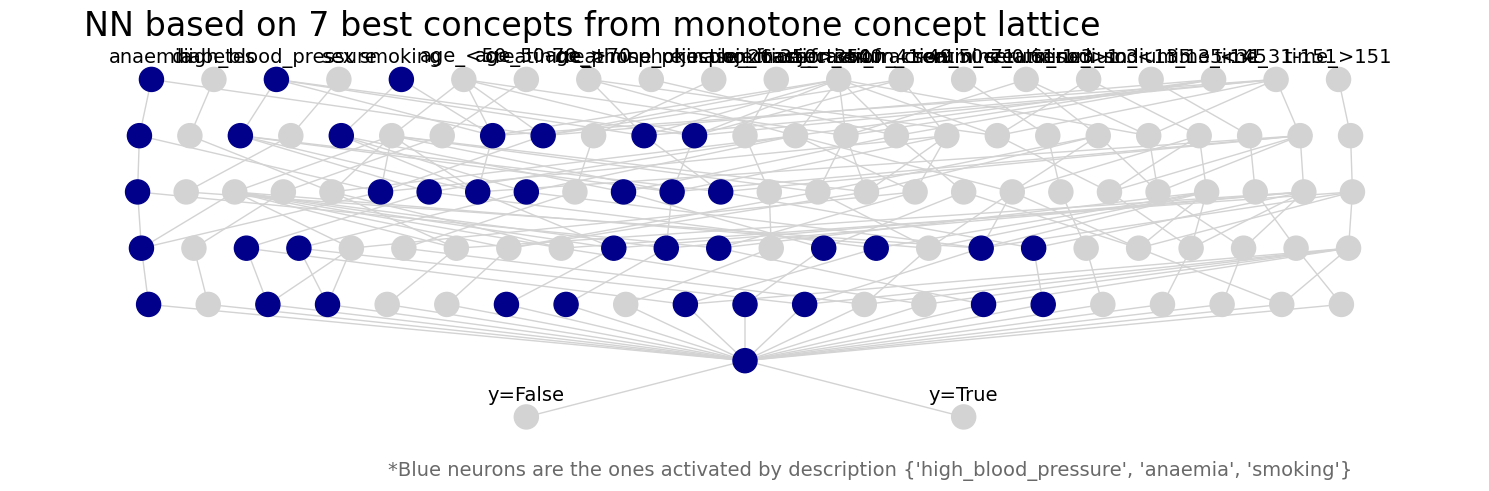

In [448]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now fit the network

In [449]:
cn.fit(X_train, y_train)

In [450]:
from sklearn.metrics import accuracy_score
# Evaluation on the training set
train_pred = cn.predict(X_train)
print("Accuracy on the training set:", accuracy_score(y_train, train_pred))

# Evaluation on the test set
test_pred = cn.predict(X_test)
print("Accuracy on the test set:", accuracy_score(y_test, test_pred))


Accuracy on the training set: 0.7624113475177305
Accuracy on the test set: 0.8


To obtain the prediction

In [451]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)

Class prediction [0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0]
Class prediction with probabilities [[9.9927908e-01 7.2091707e-04]
 [9.9927908e-01 7.2091707e-04]
 [4.5983654e-02 9.5401639e-01]
 [9.9927908e-01 7.2091707e-04]
 [9.9927908e-01 7.2091707e-04]
 [6.9535041e-01 3.0464959e-01]
 [6.9987357e-01 3.0012646e-01]
 [9.9960536e-01 3.9470865e-04]
 [4.5957889e-02 9.5404214e-01]
 [6.9535041e-01 3.0464959e-01]
 [9.9927908e-01 7.2091707e-04]
 [4.5957889e-02 9.5404214e-01]
 [9.9927908e-01 7.2091707e-04]
 [9.9927908e-01 7.2091707e-04]
 [4.5983654e-02 9.5401639e-01]
 [6.9535041e-01 3.0464959e-01]
 [9.9927908e-01 7.2091707e-04]
 [8.4823257e-01 1.5176745e-01]
 [9.9927908e-01 7.2091707e-04]
 [9.9927908e-01 7.2091707e-04]
 [3.7253600e-01 6.2746406e-01]
 [6.9535041e-01 3.0464959e-01]
 [4.5957889e-02 9.5404214e-01]
 [4.5957889e-02 9.5404214e-01]
 [3.7253600e-01 6.2

In [452]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = cn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

Accuracy: 0.8, Precision: 0.7083333333333334, Recall: 0.6071428571428571, F1 Score: 0.6538461538461539


Let us look at the fitted weights of edges

In [431]:
edge_weights = cn.edge_weights_from_network()

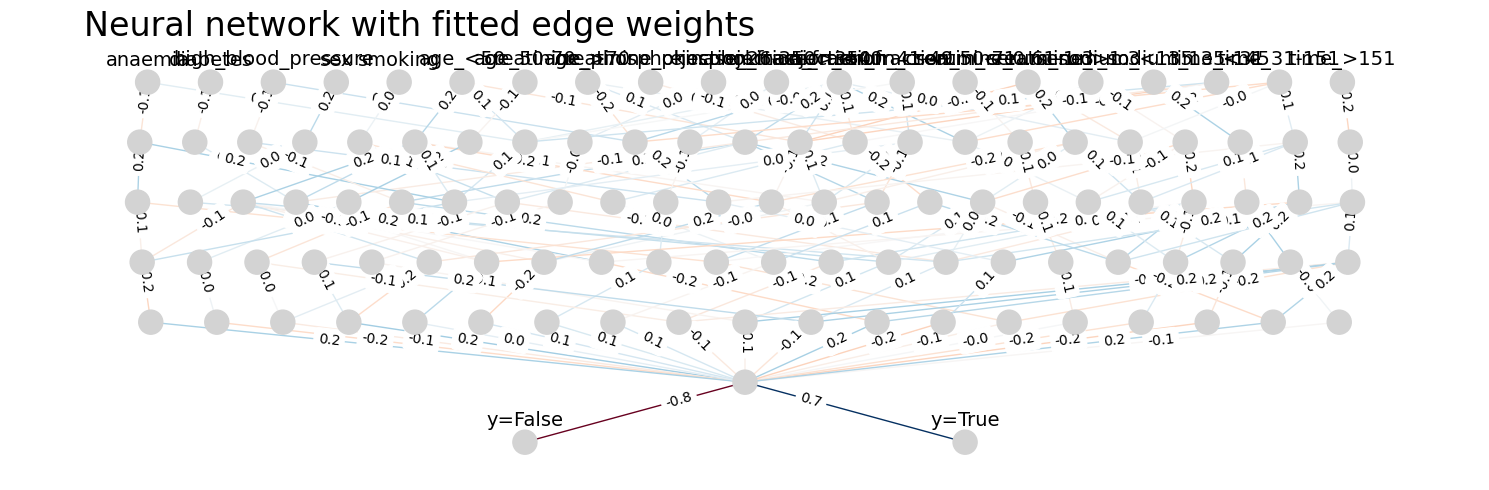

In [432]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network1.png')
plt.show()